# DOE 本番解析用 (base) v4

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [5]:
name_doe = "doe-10"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join("..", "output", name_doe, f"y{m.group(1)}", m.group(2))
    date_str = os.path.join(date_dir, m.group(3))
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00")
    date_str = os.path.join(date_dir, "00")
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

## CSV ファイルの読み込み、連結

In [6]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_latest_single.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20250819.xlsx  7011    100  1500.0           30          300
1    ticks_20250819.xlsx  7011    100  2800.0           40          300
2    ticks_20250819.xlsx  7011     70 -5300.0           50          300
3    ticks_20250819.xlsx  7011     62 -9700.0           60          300
4    ticks_20250819.xlsx  7011     42 -2800.0           70          300
..                   ...   ...    ...     ...          ...          ...
284  ticks_20250819.xlsx  7011      6  1100.0          150         1100
285  ticks_20250819.xlsx  7011      2 -1700.0          160         1100
286  ticks_20250819.xlsx  7011      2 -1700.0          170         1100
287  ticks_20250819.xlsx  7011      2 -1700.0          180         1100
288  ticks_20250819.xlsx  7011      0     0.0          190         1100

[289 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade   total  PERIOD_MA_1  PE

### 本日の条件

In [7]:
x_por = 60
y_por = 600
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

     PERIOD_MA_1  PERIOD_MA_2  取引回数     損益 備考
105           60          600    34 -900.0   


## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

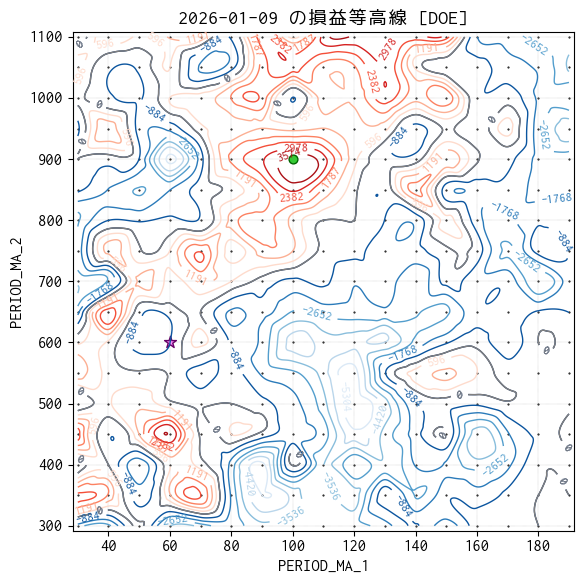

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = f"{date_str}_{name_code}_contour_single.png"

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

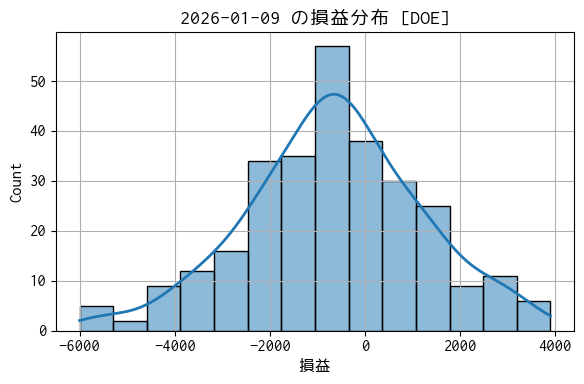

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [DOE]")

plt.tight_layout()
output = f"{date_str}_{name_code}_hist_single.png"
plt.savefig(output)
plt.show()

## 最大・最小収益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高収益")
print(df[df["total"] == total_max])
print("\n最低収益")
print(df[df["total"] == total_min])

最高収益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
15140  ticks_20251105.xlsx  7011     20  25400.0          130          600

最低収益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
13566  ticks_20251027.xlsx  7011     96 -16400.0           30         1100


## サマリ統計の算出

In [12]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
'''
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
'''
styled = (
    df_summary.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)

html = styled.to_html()
output = f"{date_str}_{name_code}_summary.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade       total
0             30          300  99.395833 -317.708333
1             40          300  92.083333 -492.708333
2             50          300  76.250000 -503.125000
3             60          300  60.854167 -631.250000
4             70          300  51.895833 -426.041667
..           ...          ...        ...         ...
284          150         1100   9.916667  -56.250000
285          160         1100   8.958333 -215.625000
286          170         1100   7.854167 -216.666667
287          180         1100   7.041667 -177.083333
288          190         1100   6.604167   51.041667

[289 rows x 4 columns]


## 日付 × 条件 で収益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で収益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で収益
                0       1        2       3       4       5       6       7    \
2025-08-19   1500.0  2800.0  -5300.0 -9700.0 -2800.0  -400.0 -1400.0 -3400.0   
2025-08-20   4000.0  2900.0   6700.0  3100.0  5000.0  6500.0  7200.0  6400.0   
2025-08-21   1700.0 -1000.0   3400.0  3600.0  4300.0  3000.0   600.0  1100.0   
2025-08-22 -10500.0 -6200.0  -6400.0 -2900.0 -4200.0 -1900.0 -1400.0 -1200.0   
2025-08-25  -4600.0 -2800.0  -2400.0 -1500.0  -500.0  -200.0   500.0 -1100.0   
...             ...     ...      ...     ...     ...     ...     ...     ...   
2026-01-05   4200.0  3500.0   6300.0 -3400.0  -800.0  2100.0  1000.0  2700.0   
2026-01-06   5700.0  4000.0   6100.0  4600.0  3900.0  1300.0 -3300.0 -2200.0   
2026-01-07   6900.0  8000.0  10500.0  7700.0  5500.0  2700.0  1500.0   300.0   
2026-01-08   -200.0 -1100.0  -5500.0 -4300.0 -5000.0 -3600.0 -6300.0 -6200.0   
2026-01-09  -2200.0 -2900.0    200.0 -3500.0 -3200.0 -2300.0 -3200.0 -2900.0   

               8   

## 平均収益の算出

In [14]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均収益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均収益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-09, n = 96 days

df_mean: 新しい日付から古い日付と逆順に平均収益を算出
                    0            1            2            3            4    \
2025-08-19  1500.000000  2800.000000 -5300.000000 -9700.000000 -2800.000000   
2025-08-20  2750.000000  2850.000000   700.000000 -3300.000000  1100.000000   
2025-08-21  2400.000000  1566.666667  1600.000000 -1000.000000  2166.666667   
2025-08-22  -825.000000  -375.000000  -400.000000 -1475.000000   575.000000   
2025-08-25 -1580.000000  -860.000000  -800.000000 -1480.000000   360.000000   
...                 ...          ...          ...          ...          ...   
2026-01-05  -442.391304  -601.086957  -647.826087  -707.608696  -457.608696   
2026-01-06  -376.344086  -551.612903  -575.268817  -650.537634  -410.752688   
2026-01-07  -298.936170  -460.638298  -457.446809  -561.702128  -347.872340   
2026-01-08  -297.894737  -467.368421  -510.526316  -601.052632  -396.842105   
2026-01-09  -317.708333  -49

### 検算

In [15]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト収益

In [16]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[str(dt_last.date())]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高収益条件")
print(df_last_max)

最終日 (2026-01-09) の最高収益条件
     PERIOD_MA_1  PERIOD_MA_2      損益
211        100.0        900.0  3900.0


## ランキング

In [17]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
'''
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
'''
styled = (
    df_best.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_best.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2       取引回数        平均損益  2026-01-09
82          170          500  10.270833  941.666667      -100.0
65          170          450  10.645833  933.333333     -1900.0
81          160          500  11.687500  859.375000      -700.0
88           60          550  45.979167  736.458333      -100.0
50          190          400   8.916667  705.208333      -300.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数         平均損益  2026-01-09
111          120          600  16.958333    -3.125000     -4100.0
268          160         1050   9.187500   -12.500000      -400.0
38            70          400  44.520833   -15.625000       300.0
133          170          650  10.062500   -21.875000     -1400.0
40            90          400  31.875000   -21.875000     -5600.0
..           ...          ...        ...          ...         ...
187           30          850  78.791667 -1037.500000      -700.0
256           40         1050  53.708333 -105

## 実験条件毎の収益トレンド

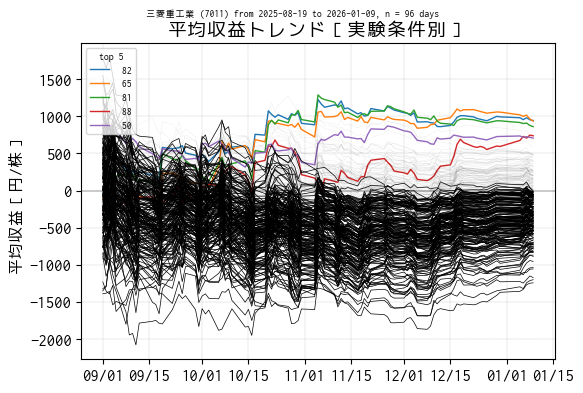

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均収益［円/株］")
ax.set_title("平均収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = f"{date_str}_{name_code}_trend_mean_profit_{target}.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (mean) の日別収益トレンド

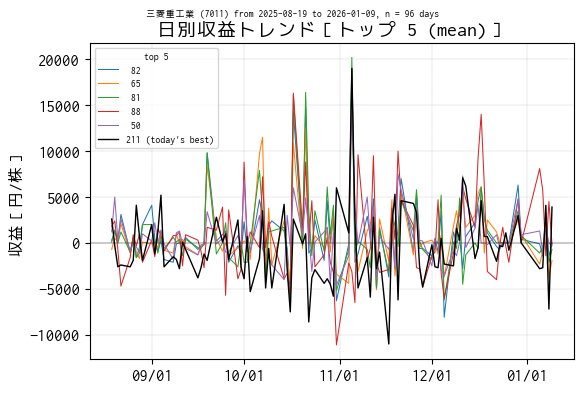

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("日別収益トレンド［トップ 5 (mean)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = f"{date_str}_{name_code}_trend_daily_profit_1.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

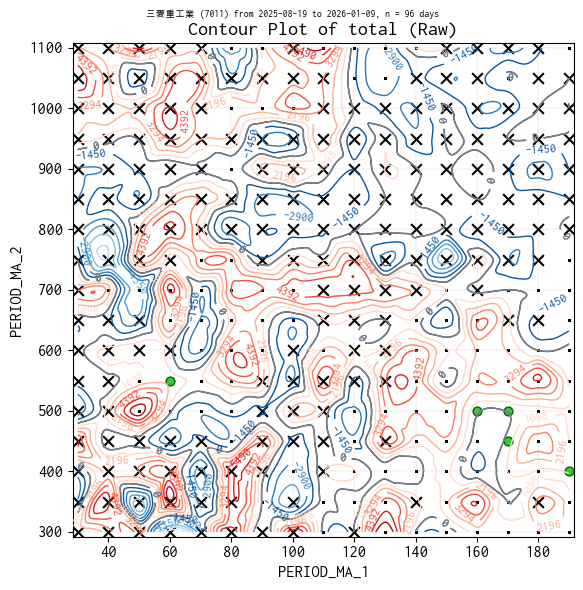

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
# cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
# ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = f"{date_str}_{name_code}_raw_contour_{target}.png"
plt.savefig(output)
plt.show()

## メディアン収益の算出

In [21]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-09, n = 96 days


In [22]:
n = len(df_median.index)

In [23]:
df_median[:n].median()

0      -300.0
1      -950.0
2     -1150.0
3     -1050.0
4     -1150.0
        ...  
284    -250.0
285    -600.0
286    -500.0
287    -450.0
288     -50.0
Length: 289, dtype: float64

In [24]:
# メディアン収益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン収益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン収益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン収益を算出
               0       1       2       3       4       5       6       7    \
2025-08-19  1500.0  2800.0 -5300.0 -9700.0 -2800.0  -400.0 -1400.0 -3400.0   
2025-08-20  2750.0  2850.0   700.0 -3300.0  1100.0  3050.0  2900.0  1500.0   
2025-08-21  1700.0  2800.0  3400.0  3100.0  4300.0  3000.0   600.0  1100.0   
2025-08-22  1600.0   900.0  -950.0   100.0   750.0  1300.0  -400.0   -50.0   
2025-08-25  1500.0 -1000.0 -2400.0 -1500.0  -500.0  -200.0   500.0 -1100.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-05  -350.0  -950.0 -1250.0 -1050.0 -1150.0 -1350.0  -300.0  -450.0   
2026-01-06  -300.0  -900.0 -1200.0  -900.0  -900.0 -1300.0  -300.0  -500.0   
2026-01-07  -300.0  -900.0 -1150.0  -800.0  -850.0 -1200.0  -300.0  -450.0   
2026-01-08  -300.0  -900.0 -1200.0  -900.0  -900.0 -1300.0  -300.0  -500.0   
2026-01-09  -300.0  -950.0 -1150.0 -1050.0 -1150.0 -1350.0  -400.0  -550.0   

               8       9 

## サマリ統計（メディアン）

In [25]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade   total
0             30          300  100.0  -300.0
1             40          300  100.0  -950.0
2             50          300   80.0 -1150.0
3             60          300   62.0 -1050.0
4             70          300   52.0 -1150.0
..           ...          ...    ...     ...
284          150         1100   10.0  -250.0
285          160         1100    8.0  -600.0
286          170         1100    8.0  -500.0
287          180         1100    6.0  -450.0
288          190         1100    6.0   -50.0

[289 rows x 4 columns]


### 検算

In [26]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [27]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
'''
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
'''
styled = (
    df_best.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = f"{date_str}_{name_code}_best_median.html"
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益  2026-01-09
45           140          400  16.0   300.0     -1700.0
124           80          650  30.0   200.0     -1900.0
63           150          450  12.0   100.0      -100.0
64           160          450  11.0   100.0     -4000.0
88            60          550  44.0   100.0      -100.0
138           50          700  50.0   100.0      1300.0
70            50          500  60.0   100.0      1000.0
106           70          600  36.0    50.0       800.0
46           150          400  14.0    50.0     -1900.0
50           190          400   8.0    50.0      -300.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益  2026-01-09
288          190         1100   6.0   -50.0     -3100.0
26           120          350  20.0   -50.0     -4000.0
150          170          700   8.0   -50.0     -1200.0
12           150          300  12.0   -50.0     -2200.0
107           80          600  30.0   -50.0     -1000.0
..   

## 実験条件毎の収益トレンド（メディアン）

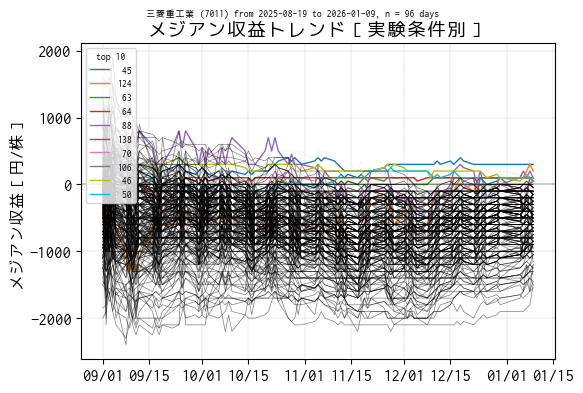

In [28]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン収益［円/株］")
ax.set_title("メジアン収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = f"{date_str}_{name_code}_trend_median_profit_{target}.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別収益トレンド

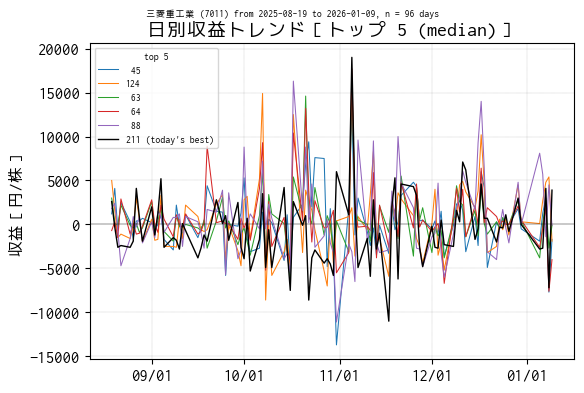

In [29]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("日別収益トレンド［トップ 5 (median)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = f"{date_str}_{name_code}_trend_daily_profit_2.png"
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()